<a href="https://colab.research.google.com/github/suchita-shakya/Infinite-Claims-Categorization-Project/blob/main/ClaimsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of Medicare claims into inpatient, outpatient and pharmacy claim data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

Extract the dataset(outpatient, inpatient and professional)

In [2]:
inpatient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176549_DE1_0_2008_to_2010_Inpatient_Claims_Sample_1/Inpatient.csv', low_memory=False)
outpatient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176616_DE1_0_2008_to_2010_Outpatient_Claims_Sample_1/Outpatient.csv', low_memory=False)
pharmacy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_1.csv', low_memory=False)

In [3]:

# Add claim type labels
inpatient['claim_type'] = 'Inpatient'
outpatient['claim_type'] = 'Outpatient'
pharmacy['claim_type'] = 'Pharmacy'

In [4]:

# Combine datasets
df = pd.concat(
    [inpatient, outpatient,pharmacy], ignore_index=True)

Extract relevant features for classification

In [5]:
# Convert date columns to datetime
df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], errors='coerce')
df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], errors='coerce')

# Feature: Claim duration in days
df['claim_duration_days'] = (df['CLM_THRU_DT'] - df['CLM_FROM_DT']).dt.days

In [6]:
# ICD-9 Procedure Codes
icd_procedure_cols = [f'ICD9_PRCDR_CD_{i}' for i in range(1, 7)]

# HCPCS Procedure Codes
hcpcs_procedure_cols = [f'HCPCS_CD_{i}' for i in range(1, 46)]

# Combine all procedure columns
procedure_cols = icd_procedure_cols + hcpcs_procedure_cols

for procedure_code in procedure_cols:
    df[procedure_code] = df[procedure_code].astype('category').cat.codes



In [7]:
#diagcode
diagnosis_cols = [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)]
for diagnosis_code in diagnosis_cols:
    df[diagnosis_code] = df[diagnosis_code].astype('category').cat.codes


In [8]:
df['claim_type_encoded'] = df['claim_type'].astype('category').cat.codes

In [9]:
#amount
amount_features = [
    'CLM_PMT_AMT',
    'NCH_PRMRY_PYR_CLM_PD_AMT',
    'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
    'NCH_BENE_PTB_DDCTBL_AMT',
    'NCH_BENE_PTB_COINSRNC_AMT',
    'TOT_RX_CST_AMT'
]

In [10]:
df.to_csv('claims_final.csv', index=False)
df.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,NCH_BENE_PTB_COINSRNC_AMT,PDE_ID,SRVC_DT,PROD_SRVC_ID,QTY_DSPNSD_NUM,DAYS_SUPLY_NUM,PTNT_PAY_AMT,TOT_RX_CST_AMT,claim_duration_days,claim_type_encoded
0,00013D2EFD8E45D1,1.966612e+14,1.0,1970-01-01 00:00:00.020100312,1970-01-01 00:00:00.020100313,2600GD,4000.0,0.0,3.139084e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,00016F745862898F,1.962012e+14,1.0,1970-01-01 00:00:00.020090412,1970-01-01 00:00:00.020090418,3900MB,26000.0,0.0,6.476809e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,00016F745862898F,1.966612e+14,1.0,1970-01-01 00:00:00.020090831,1970-01-01 00:00:00.020090902,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,00016F745862898F,1.960912e+14,1.0,1970-01-01 00:00:00.020090917,1970-01-01 00:00:00.020090920,3913XU,5000.0,0.0,4.971603e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,00016F745862898F,1.962612e+14,1.0,1970-01-01 00:00:00.020100626,1970-01-01 00:00:00.020100701,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [11]:
all_features = diagnosis_cols + icd_procedure_cols + hcpcs_procedure_cols + amount_features + ['claim_duration_days']
df[all_features] = df[all_features].fillna(0)

Build a classification model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [13]:
# Features and target
#date_features = ['claim_duration_days']
X = df[all_features]
y = df['claim_type_encoded']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Train model
model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13319
           1       1.00      1.00      1.00    158521
           2       1.00      1.00      1.00   1110157

    accuracy                           1.00   1281997
   macro avg       1.00      1.00      1.00   1281997
weighted avg       1.00      1.00      1.00   1281997



Visualization


              precision    recall  f1-score   support

   Inpatient       1.00      1.00      1.00     13319
  Outpatient       1.00      1.00      1.00    158521
    Pharmacy       1.00      1.00      1.00   1110157

    accuracy                           1.00   1281997
   macro avg       1.00      1.00      1.00   1281997
weighted avg       1.00      1.00      1.00   1281997



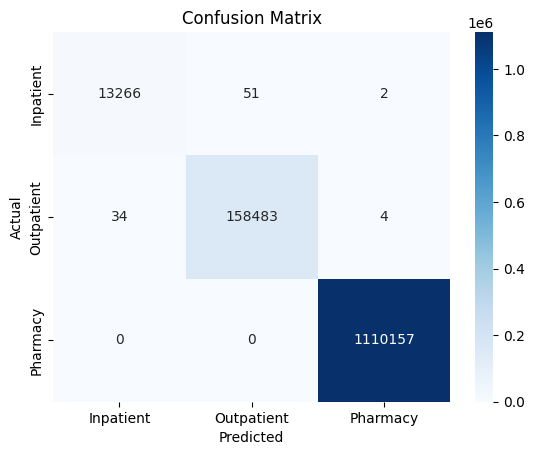

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Inpatient', 'Outpatient','Pharmacy']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inpatient', 'Outpatient','Pharmacy'], yticklabels=['Inpatient', 'Outpatient','Pharmacy'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()